In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from trainer.segnet import build_encoder_decoder, build_refinement
from trainer.utils import get_final_output
from trainer.data_generator import composite4

Using TensorFlow backend.


Downloaded 'gs://secret-compass-237117-mlengine/all_data/fg_names.txt'
Downloaded 'gs://secret-compass-237117-mlengine/all_data/bg_names.txt'


NameError: name 'cv' is not defined

In [51]:
img_rows, img_cols = 320, 320
channel = 3
checkpoint_path = '/Users/erez/Downloads/deep_image_matting_20190509_145329_checkpoints_stageless.95-0.0010.hdf5'
checkpoint_path = '/Users/erez/Downloads/deep_image_matting_20190513_195202_checkpoints_encoder_decoder.44-0.0062.hdf5'
#checkpoint = '../models/final.42-0.0398.hdf5'


imageName = "0cdf5b5d0ce1_05"
#imageName = "26ccab021981_07"

bg = cv.imread('/Users/erez/Desktop/data/test/background_test/1844.jpg')
fg = cv.imread('/Users/erez/Desktop/data/test/carvana/' + imageName + '.jpg')
#fg = cv.imread('/Users/erez/Desktop/data/test/bike.jpg')
gt = cv.imread('/Users/erez/Desktop/data/test/carvana/' + imageName + '_mask.jpg' ,0)



In [33]:
final = build_encoder_decoder()
#final = build_refinement(final)

final.load_weights(checkpoint_path)

#print(final.summary())

In [52]:
x_test = np.empty((1, img_rows, img_cols, channel), dtype=np.float32)

if fg.shape[0] != 320: 
    fg = cv.resize(fg, (img_rows, img_cols))
    gt = cv.resize(gt, (img_rows, img_cols))
    
    
x_test[0, :, :, 0:3] = fg / 255.
#try testing with a composite instead of the original image: 
x_test[0, :, :, 0:3] = composite(fg, bg, gt, 320, 320) / 255.

if channel > 3:
    trimap = generate_trimap(gt)
    if trimap.shape[0] != 320: 
        trimap = cv.resize(trimap, (img_rows, img_cols))
    x_test[0, :, :, 3] = trimap / 255.

In [53]:
out = final.predict(x_test)
out = np.reshape(out, (img_rows, img_cols))

out = out * 255.0

#if channel > 3: 
    #out = get_final_output(out, trimap)
out = out.astype(np.uint8)

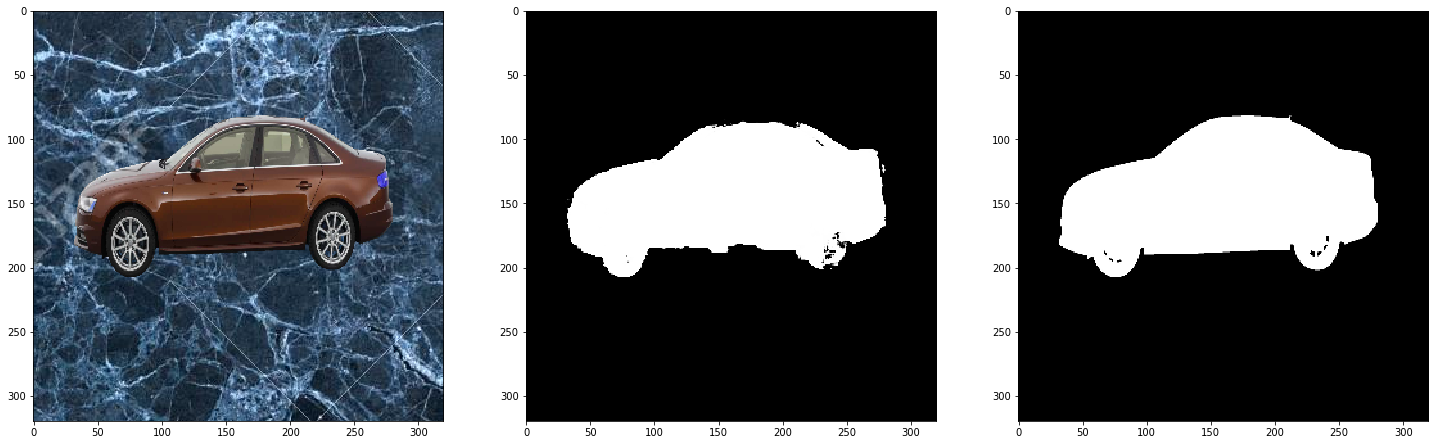

In [54]:
f, ax = plt.subplots(1,3,figsize=(25,25))

ax[0].imshow(x_test[0, :, :, 0:3] )
ax[1].imshow(out, cmap = 'gray')
ax[2].imshow(gt, cmap = 'gray')

In [76]:
k, t = cv.threshold(out,127,255,cv.THRESH_BINARY)
blur = cv.bilateralFilter(t,9,120,120)

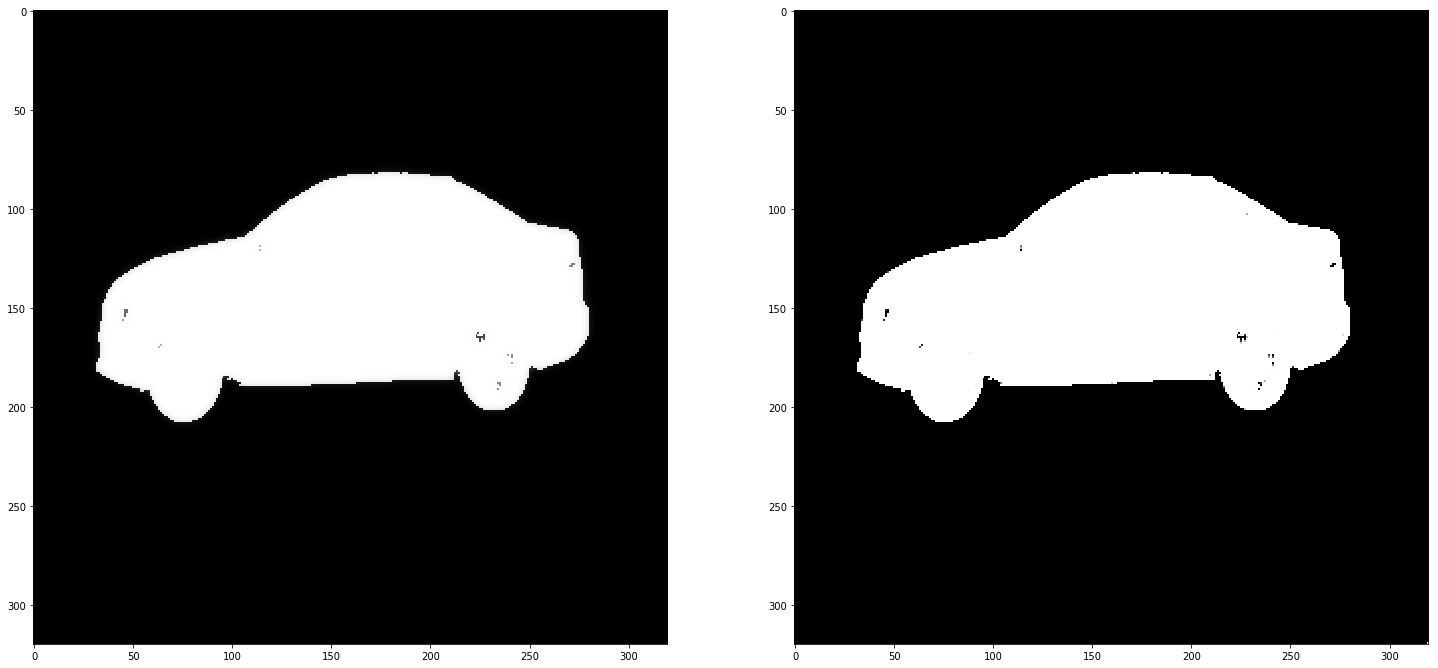

In [77]:
f, ax = plt.subplots(1,2,figsize=(25,25))

ax[0].imshow(blur, cmap = 'gray')
ax[1].imshow(out, cmap = 'gray')

In [7]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
def generate_trimap(alpha):
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    # fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 3))
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv.dilate(unknown, kernel, iterations=np.random.randint(1, 20))
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)


In [6]:
def composite(fg, bg, a, w, h):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a / 255.
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im

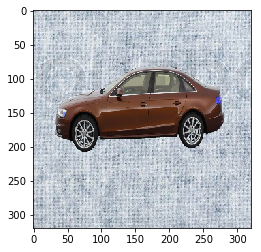